In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
from cider.validation_metrics.dependencies import (
    convert_threshold_to_percentile, 
    calculate_weighted_spearmanr, 
    calculate_weighted_pearsonr,
    calculate_metrics_binary_valued_consumption,
    calculate_utility,
    calculate_rank_residuals_by_characteristic,
    calculate_demographic_parity_per_characteristic,
    calculate_independence_btwn_proxy_and_characteristic,
    calculate_precision_and_recall_independence_characteristic)
from cider.validation_metrics.schemas import ConsumptionColumn
from cider.validation_metrics.core import (
    compute_auc_roc_precision_recall_with_percentile_grid, 
    compute_utility_grid, 
    calculate_optimal_utility_and_cash_transfer_size_table,
    calculate_rank_residuals_table_by_characteristic,
    calculate_demographic_parity_table_per_characteristic,
    combine_tables_on_characteristic,)
from cider.validation_metrics.plotting import (
    plot_roc_precision_recall_curves,
    plot_utility_values,
    plot_rank_residual_distributions_per_characteristic_value,
    plot_demographic_parity_per_characteristic_value)
import numpy as np
import pandas as pd

In [3]:
# Make synthetic data

n_rows = 1000
n_proxies = 10
synthetic_data = {}

np.random.seed(2)
synthetic_data['household_id'] = range(n_rows)
synthetic_data['groundtruth_consumption'] = np.random.rand(n_rows) * 10
for i in range(10):
    synthetic_data["proxy_consumption"] = synthetic_data['groundtruth_consumption'] + np.random.uniform(size=n_rows, low=0, high=i+5)
synthetic_data['weight'] = np.random.randint(10, 100, size=n_rows)

synthetic_df = pd.DataFrame(synthetic_data)
synthetic_df

,household_id,groundtruth_consumption,proxy_consumption,weight
0,0,4.359949,4.992880,75
1,1,0.259262,3.910949,83
2,2,5.496625,17.490485,21
3,3,4.353224,16.202991,53
4,4,4.203678,8.119494,85
...,...,...,...,...
995,995,5.985047,13.115803,89
996,996,3.589201,13.024588,13
997,997,6.803915,8.792285,17
998,998,8.531998,13.013903,24


In [4]:
# Calculate Spearman's R
spearman_r = calculate_weighted_spearmanr(synthetic_df, 3)
print(f"Spearman's R: {spearman_r}")

# Calculate Pearson's R
pearson_r = calculate_weighted_pearsonr(synthetic_df, 3)
print(f"Pearson's R: {pearson_r}")

Spearman's R: 0.517
Pearson's R: 0.55


In [5]:
convert_threshold_to_percentile(2.5, synthetic_df)

np.float64(24.522906183113836)

In [6]:
calculate_metrics_binary_valued_consumption(synthetic_df, 50, 20)

,accuracy,precision,recall,true_positive_rate,false_positive_rate,auc,roc_curve,spearman_r,pearson_r
0,0.656886,0.867562,0.346582,0.346582,0.04998,0.74721,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.52,0.55


In [7]:
calculate_utility(
    synthetic_df,
    20.0, 
    ConsumptionColumn.GROUNDTRUTH,
    5000)

np.float64(-27.708964079102465)

In [8]:
fixed_groundtruth_percentile = 40  # Bottom 40% are considered "poor"
auc_roc_precision_recall_df = compute_auc_roc_precision_recall_with_percentile_grid(
    synthetic_df,
    fixed_groundtruth_percentile,
    99)
auc_roc_precision_recall_df

,percentile,precision,recall,true_positive_rate,false_positive_rate,auc
0,99.0,0.390546,1.000000,1.000000,0.982566,0.760685
1,98.0,0.394339,1.000000,1.000000,0.967059,0.760685
2,97.0,0.398002,1.000000,1.000000,0.952365,0.760685
3,96.0,0.402522,1.000000,1.000000,0.934600,0.760685
4,95.0,0.405739,1.000000,1.000000,0.922194,0.760685
...,...,...,...,...,...,...
94,5.0,1.000000,0.135383,0.135383,0.000000,0.760685
95,4.0,1.000000,0.105495,0.105495,0.000000,0.760685
96,3.0,1.000000,0.074267,0.074267,0.000000,0.760685
97,2.0,1.000000,0.051887,0.051887,0.000000,0.760685


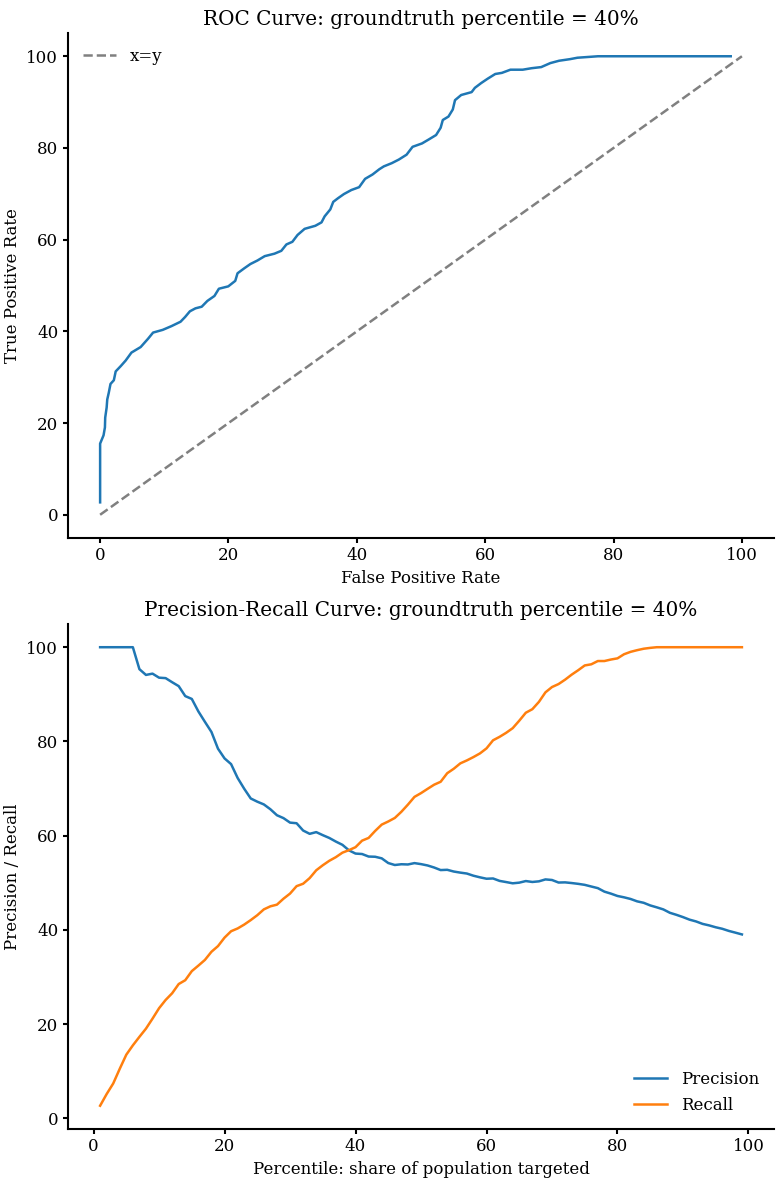

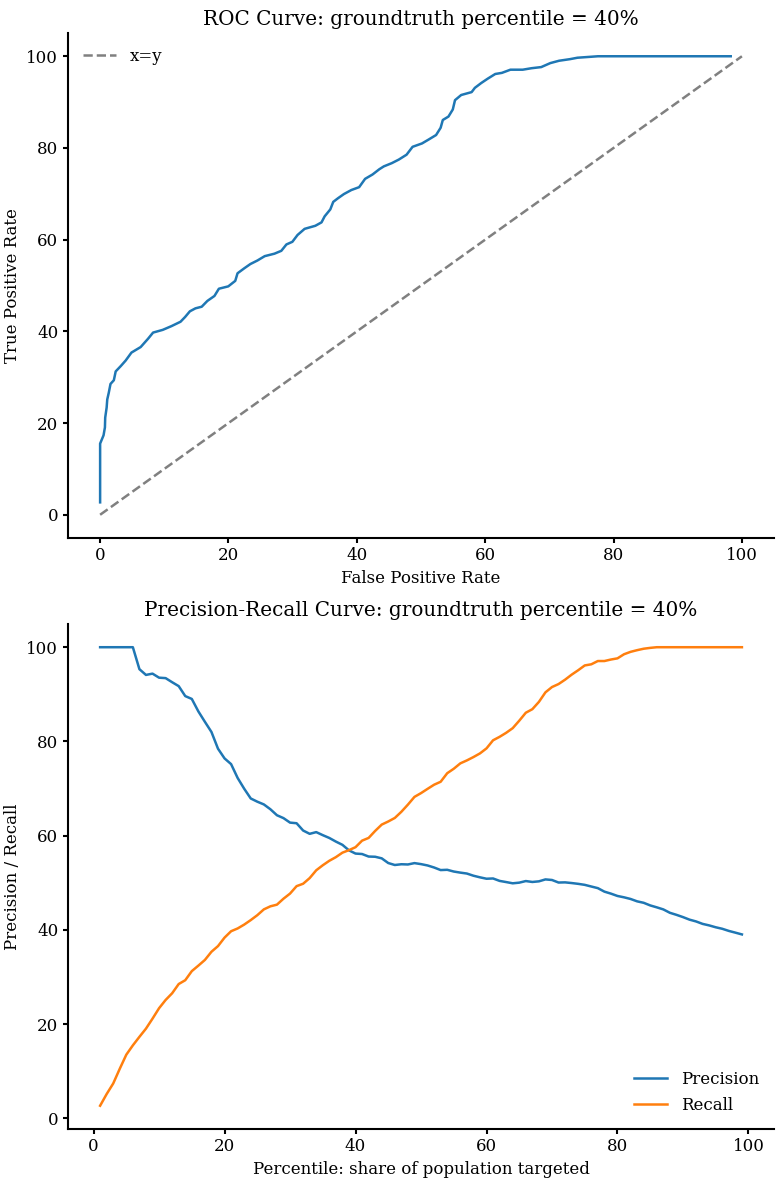

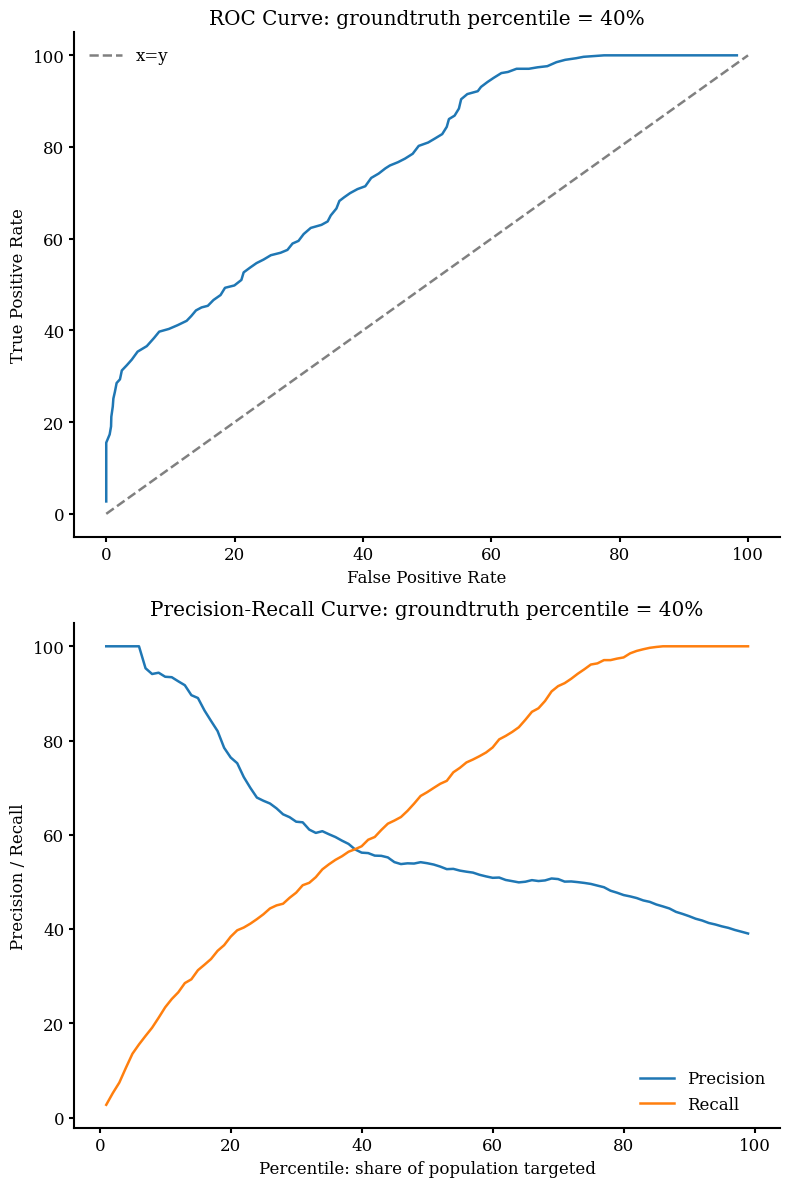

In [9]:
# PLot ROC Curve
fig, ax = plot_roc_precision_recall_curves(auc_roc_precision_recall_df, fixed_groundtruth_percentile)
fig

In [10]:
cash_transfer_at_ubi_rate = 0.1 * synthetic_df['weight'].sum()
utility_grid_df = compute_utility_grid(
    synthetic_df,
    cash_transfer_amount=cash_transfer_at_ubi_rate,
    num_grid_points=99,
    constant_relative_risk_aversion=3.0)
utility_grid_df

,percentile,cash_transfer_amount_groundtruth,cash_transfer_amount_proxy,utility_groundtruth,utility_proxy
0,1.000000,523069.800714,517524.891166,-510.433424,-7.362660
1,2.010204,257851.310211,254270.042014,-194.037781,-6.453718
2,3.020408,190454.543823,182617.885536,-130.755862,-5.903647
3,4.030612,136814.146847,131708.223201,-101.374665,-5.494289
4,5.040816,107849.443446,102562.706022,-83.256659,-5.151840
...,...,...,...,...,...
94,95.959184,5649.682497,5641.521675,-9.889267,-2.612599
95,96.969388,5583.878310,5582.814066,-9.996909,-2.628555
96,97.979592,5526.566703,5532.516544,-10.093290,-2.642528
97,98.989796,5474.713823,5478.297488,-10.182426,-2.658128


In [11]:
optimal_utility_df = calculate_optimal_utility_and_cash_transfer_size_table(
    synthetic_df,
    cash_transfer_amount=cash_transfer_at_ubi_rate,
    num_grid_points=10,
    constant_relative_risk_aversion=3.0
)
optimal_utility_df

,optimal_population_percentile,maximum_utility,optimal_transfer_size
groundtruth_consumption,67.0,-7.999625,8115.900709
proxy_consumption,56.0,-2.168803,9698.344151


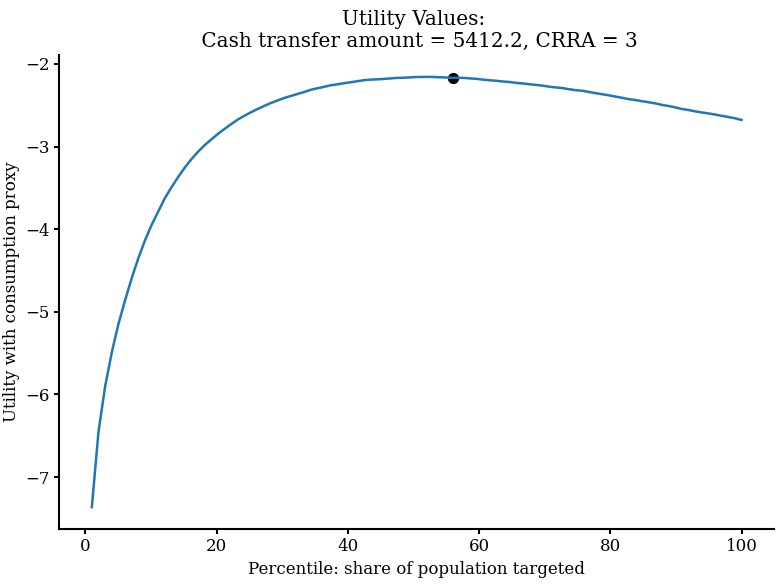

In [12]:
fig, ax = plot_utility_values(
    utility_grid_df, 
    optimal_utility_df.loc["proxy_consumption", "optimal_population_percentile"],
    optimal_utility_df.loc["proxy_consumption", "maximum_utility"],
    cash_transfer_at_ubi_rate, 3)
fig

In [12]:
# Add characteristic for fairness analysis
allowed_gender_values = {'male', 'female', 'other'}
synthetic_df_gender = synthetic_df.copy()
synthetic_df_gender['characteristic'] = np.random.choice(list(allowed_gender_values), size=len(synthetic_df_gender))


In [13]:
results = calculate_rank_residuals_by_characteristic(
    synthetic_df_gender)
results

In [14]:
calculate_demographic_parity_per_characteristic(
    synthetic_df_gender,
    threshold_percentile=50)

characteristic
female    [-3.8339307490484464e-05, 0.000131924171316654...
male      [0.0005016444329477846, -0.00010165921436754, ...
other     [-0.0001938583200916448, -2.6440264587413622e-...
Name: rank_residual, dtype: object

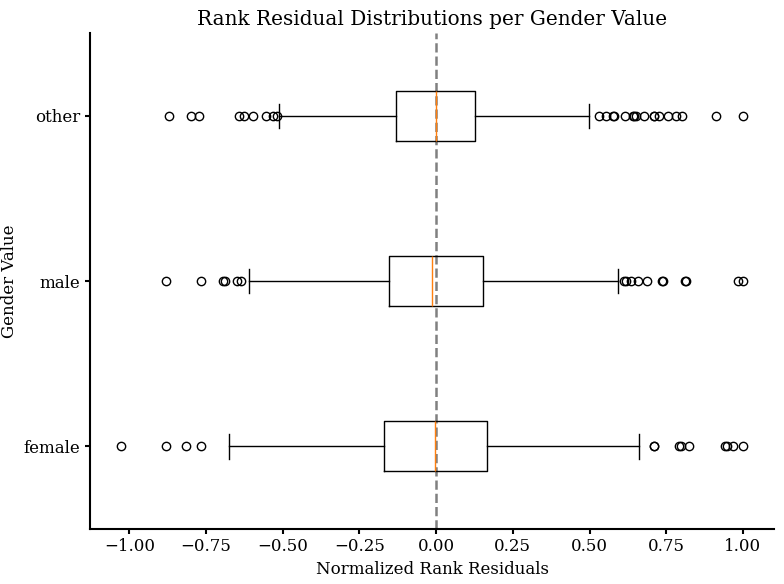

In [16]:
# Plot rank residual distributions per characteristic value
fig, ax = plot_rank_residual_distributions_per_characteristic_value(results, "Gender")
fig

In [65]:
pivot_independence, results = calculate_independence_btwn_proxy_and_characteristic(
    synthetic_df_gender,
    threshold_percentile=50)
results

,chi2_statistic,p_value
0,38.604877,4.140544e-09


In [66]:
precision_per_group, recall_per_group, results = calculate_precision_and_recall_independence_characteristic(
    synthetic_df_gender,
    50,
    50)
results

,chi2_statistic,p_value
precision,9.943597,0.006931
recall,2.431238,0.296526


In [ ]:
df, anova_f_statistic, anova_p_value = calculate_rank_residuals_table_by_characteristic(
    synthetic_df_gender)
print(f"ANOVA F-statistic: {anova_f_statistic}, p-value: {anova_p_value}")
df

In [79]:
demographic_table = calculate_demographic_parity_table_per_characteristic(
    synthetic_df_gender,
    50
)
demographic_table

,groundtruth_poverty_percentage,proxy_poverty_percentage,demographic_parity,population_percentage
characteristic,,,,
female,17.216659,17.017109,-0.199549,33.703485
male,16.200436,16.634640,0.434204,33.119619
other,15.160194,15.769927,0.609734,33.176897


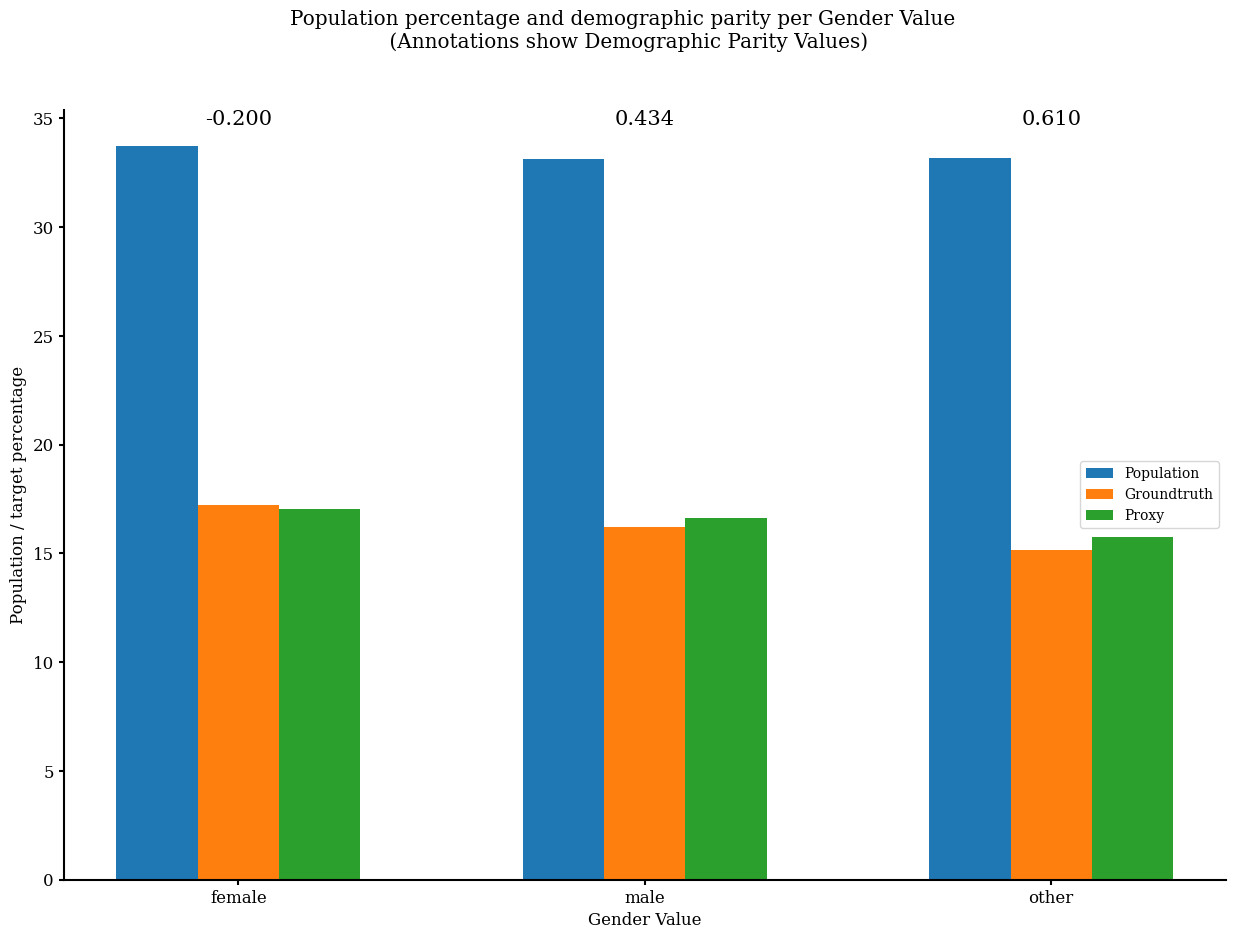

In [80]:
fig, ax = plot_demographic_parity_per_characteristic_value(demographic_table, "Gender")
fig

In [69]:
combined_table, combined_results, statistics = combine_tables_on_characteristic(
    synthetic_df_gender,
    50
)

In [78]:
combined_table.merge(combined_results.filter(like="_percentage"), left_index=True, right_index=True)

,independence_0,independence_1,precision_0,precision_1,recall_0,recall_1,groundtruth_poverty_percentage,proxy_poverty_percentage,population_percentage
characteristic,,,,,,,,,
female,9031,9210,3271,5939,3379,5939,51.082726,50.490653,33.703485
male,8922,9003,3350,5653,3115,5653,48.914923,50.225941,33.119619
other,9421,8535,3215,5320,2885,5320,45.695032,47.532858,33.176897


In [73]:
combined_results

,mean_rank_residual,std_rank_residual,groundtruth_poverty_percentage,proxy_poverty_percentage,demographic_parity,population_percentage
characteristic,,,,,,
female,1.429737e-06,0.000307,51.082726,50.490653,-0.592073,33.703485
male,-8.279355e-07,0.000319,48.914923,50.225941,1.311018,33.119619
other,1.154160e-05,0.000319,45.695032,47.532858,1.837826,33.176897


In [74]:
statistics

,anova_f_statistic,anova_p_value,independence_chi2,independence_p_value,precision_chi2,precision_pvalue,recall_chi2,recall_pvalue
0,0.14462,0.86537,38.604877,4.140544e-09,9.943597,0.006931,2.431238,0.296526
